In [1]:
import torch
from dataset import *
from save_load import *
from NN_library.AutoUnet.AutoUnet import *
from NN_library.ConvNet.ConvNet import *

Using device: cuda
Using device: cuda


In [30]:
torch.__version__

'2.0.1'

### AutoUnet

In [2]:
name = 'NN_library/AutoUnet/AutoUnet'
args = {'dev' : dev, 'name' : name}
unet = AutoUNet()
unet = load_network(unet, args['name'], args)

In [3]:
data = dataset_nonuniform()

In [4]:
geometry, damage, imp_shrinkage, _, _ = data.__getitem__(0)
n = 0
# An example input you would normally provide to your model's forward() method.
example = torch.cat([geometry, imp_shrinkage[[n+1]] / -0.001, damage[[n],:,:]], axis=1).view(1,3,99,99)

In [5]:
# Use torch.jit.trace to generate a torch.jit.ScriptModule via tracing.
traced_script_module = torch.jit.trace(unet, example)
traced_script_module.save("AutoUnet.pt")

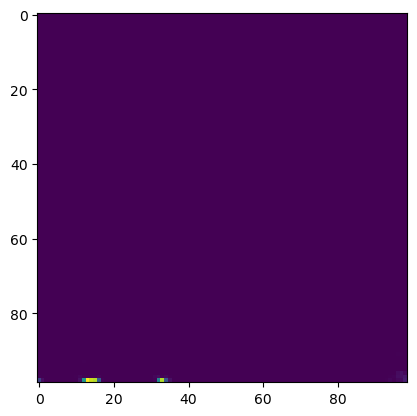

In [6]:
output = traced_script_module(example)
plt.imshow(output[0, 0].detach())

In [7]:
output[0, 0]

tensor([[4.9765e-05, 1.9431e-07, 2.8542e-09,  ..., 2.1192e-08, 7.3569e-07,
         4.0847e-05],
        [6.1513e-07, 1.9478e-10, 2.3404e-10,  ..., 1.0435e-08, 3.9788e-09,
         2.8679e-07],
        [3.8542e-10, 1.0126e-08, 6.3288e-10,  ..., 1.2480e-09, 2.4255e-09,
         6.5944e-07],
        ...,
        [3.2045e-05, 3.2665e-07, 9.0237e-11,  ..., 4.4464e-04, 6.8636e-04,
         3.4134e-04],
        [1.5427e-04, 1.7526e-05, 5.8676e-08,  ..., 4.9848e-04, 6.0610e-04,
         9.7417e-04],
        [2.7486e-03, 5.6001e-04, 4.2899e-05,  ..., 2.8333e-04, 4.3327e-04,
         1.1778e-03]], grad_fn=<SelectBackward0>)

### Save values

In [8]:
class Container(torch.nn.Module):
    def __init__(self, my_values):
        super().__init__()
        for key in my_values:
            setattr(self, key, my_values[key])

input = {
    '0': example
}

input_shrinkage = {
    'imp_shrinkage': (imp_shrinkage[1:] / -0.001).view(-1,1,99,99)
}

# Save arbitrary values supported by TorchScript
# https://pytorch.org/docs/master/jit.html#supported-type
container = torch.jit.script(Container(input))
container.save("Autounet_input.pt")
container = torch.jit.script(Container(input_shrinkage))
container.save("imposed_shrinkage.pt")

### Convnet

In [9]:
name = 'NN_library/ConvNet/ConvNet'
args = {'dev' : dev, 'name' : name}
net = ConvNet(16)
net = load_network(net, args['name'], args)

In [10]:
geometry, damage, imp_shrinkage, _, _ = data.__getitem__(0)
n = 1
example = torch.cat([geometry, imp_shrinkage[[n]] / -0.001, damage[[n],:,:]], axis=1).view(1,3,99,99)

In [11]:
traced_script_module = torch.jit.trace(net, example)
traced_script_module.save("ConvNet.pt")

In [12]:
output = traced_script_module(example)
output

tensor([[1.0000, 0.0065]], grad_fn=<SigmoidBackward0>)

In [13]:
input = {
    '0': example
}
container = torch.jit.script(Container(input))
container.save("Convnet_input.pt")